## Generate sequences for AAV2 Chip with agilent 


Design of the tile is outlined below

Number in parenthesis are the size of each element 

oh=overhang 

SkppF(15)---3BbsI(6)---oh(5)---VariantSeq---oh(5)---5BsaI(6)---EcoRV(6)---3BsaI(6)---Bar_oh(5)---Barcode(20)---Bar_oh(5)---5BbsI(6)---SkppR(15)


The first 3 components before the VariantSeq are labeled "upstream" in the code, and the ones after are refered to as downstream. All assemblies need to be checked to not introduce any cut sites for other enzymes used in cloning.

### Notes :
* Due to randomness in this code, running this will not result in the same exact set of nucleotide variants, as barcodes get matched randomly, and backtranslations from AA seq to nt has randomness associated with it. 
* This chip design includes barcodes, which were not used in the post-experiment analysis, as the full amplicon sequencing provided sufficient quality. 

In [ ]:
path_to_synthesis_files='../Data/data_for_synthesis_pipeline/'

In [1]:
import csv  
from collections import Counter 
from itertools import product
import os
import pickle
import re
import sys 
import random
import pdb
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from Bio import SeqIO 
from Bio.Data import CodonTable
from Bio.Restriction import BbsI, BsaI, BsmBI, EcoRV, HindIII, XbaI, ScaI,BsrBI
from Bio.Seq import Seq 
from Bio.SeqUtils import MeltingTemp as mt
import pandas as pd
import numpy as np

In [2]:
import editdistance

In [3]:
%reload_ext autoreload
%autoreload 2
from src.oligo import *
from src.oligo import Oligo

In [4]:
WT_NT_AAV2_T21= 'GACGAAGAGGAAATCAGGACAACCAATCCCGTGGCTACGGAGCAGTATGGTTCTGTATCTACCAACCTCCAGAGAGGCAACAGA'
WT_AA_AAV2_T21 = 'DEEEIRTTNPVATEQYGSVSTNLQRGNR'


In [5]:
re_list = []
for x in [BsaI, HindIII, XbaI, BbsI, BsmBI, EcoRV,BsrBI]:
    re_list.append(x.site)
    rc = str(Seq(x.site).reverse_complement())
    if rc != x.site:
        re_list.append(rc)
homopolymer=[]
for nt in ['A', 'C', 'G', 'T']:
    for n in range(5,6):
        site = ''.join([nt]*n)
        re_list.append(site)
        homopolymer.append(site)
print (re_list)

['GGTCTC', 'GAGACC', 'AAGCTT', 'TCTAGA', 'GAAGAC', 'GTCTTC', 'CGTCTC', 'GAGACG', 'GATATC', 'CCGCTC', 'GAGCGG', 'AAAAA', 'CCCCC', 'GGGGG', 'TTTTT']


In [7]:
homopolymer

['AAAAA', 'CCCCC', 'GGGGG', 'TTTTT']

In [6]:
def compute_BC_OH(enz):
    nts=["A","T","G","C"]
    seq=enz.site
    start_filter=seq[-1]
    end_filter=seq[0]
    if end_filter in nts[:2]:
        OH_BC_5=nts[3]+seq[1:5]
    else:
        OH_BC_5=nts[0]+seq[1:5]
    
    if start_filter =="A":
        OH_BC_3=seq[1:5]
        appendix="TT"
    else:
        OH_BC_3=seq[1:5]
        appendix="AA"
    rev_comp_OH_BC_3=str(Seq(OH_BC_3))+appendix
    print (rev_comp_OH_BC_3)
    return OH_BC_5,rev_comp_OH_BC_3,start_filter,end_filter

In [7]:
OH_BC_5,OH_BC_3,start_filter,end_filter=compute_BC_OH(BsrBI)

CGCTAA


In [8]:
OH_BC_3,OH_BC_5

('CGCTAA', 'ACGCT')

### Generating Barcodes
Only run this part if you want to make new barcodes.
Otherwise skip to next section marked "RUN FROM HERE"

In [21]:
OH_BC_5,OH_BC_3,start_filter,end_filter=compute_BC_OH(BsrBI)

CGCTAA


In [ ]:
candidates_odd=[]
candidates_even=[]
with open(f'{path_to_synthesis_files}barcodes16-1.txt',"r") as all_barcodes:
    count=0
    for line in all_barcodes :
        
        skip=False
        seq=line.strip("\n")
        
       # if line.startswith(start_filter) or line.endswith(end_filter): #filter barcodes
        #    count+=1
         #   continue
        #else:
        for re in re_list:
            if re in seq:
               skip=True
        if not skip:
            if count %2==0:
                candidates_even.append(seq)
            else:
                candidates_odd.append(seq)
        count+=1

In [184]:
len(candidates_odd),len(candidates_even)

(793042, 793035)

In [185]:
short_bc=["A","C","T","G"]

In [186]:
def compute_left_right_appendix(bc,shorts,start_filter,end_filter):
    left=random.choice(shorts)
    while left.endswith(bc[0]) or left.startswith(start_filter):
          left=random.choice(shorts)
    right=random.choice(shorts)
    while right.startswith(bc[-1]) or right.endswith(end_filter):
          right=random.choice(shorts)
    return left,right

def assemble_compound_barcodes(shorts,longs,start_filter,end_filter,re_list):
    compound_bcs=[]
    for bc in longs:
        left,right=compute_left_right_appendix(bc,shorts,start_filter,end_filter)
        count=0
        while check_re_sites(left+bc+right,re_list)!=0 and count<1000:
            left,right=compute_left_right_appendix(bc,shorts,start_filter,end_filter)
            count+=1
        if count==1000:
            continue
        else:
            compound_bcs.append(left+bc+right)
    return compound_bcs
             
        

In [ ]:
comp_barcodes_odd=assemble_compound_barcodes(short_bc,candidates_odd,start_filter,end_filter,re_list)

In [ ]:
comp_barcodes_even=assemble_compound_barcodes(short_bc,candidates_even,start_filter,end_filter,re_list)

In [ ]:
len(comp_barcodes_odd),len(set(comp_barcodes_odd)),len(comp_barcodes_even),len(set(comp_barcodes_even))

In [20]:
dists_odd=[]
dists_even=[]
for i in range(1000):
    for j in range(1000):
        seq1=random.choice(comp_barcodes_odd)
        seq2=random.choice(comp_barcodes_odd)
        if seq1!=seq2:
            dists_odd.append(editdistance.eval(seq1,seq2))
        seq1=random.choice(comp_barcodes_even)
        seq2=random.choice(comp_barcodes_even)
        if seq1!=seq2:
            dists_even.append(editdistance.eval(seq1,seq2))
print (min(dists_odd),min(dists_even))

3 3


In [22]:
comp_barcodes_even[:10]

['GAACAACAACAACAACCG',
 'GAACAACAACAACCGCAG',
 'GAACAACAACAAGCTCCT',
 'TAACAACAACACAAGAGT',
 'TAACAACAACACCATGCT',
 'GAACAACAACACGCCACG',
 'GAACAACAACACTCTAGT',
 'TAACAACAACAGACCTAG',
 'TAACAACAACAGGAAGGT',
 'GAACAACAACAGTAGCAT']

In [23]:
file_1_candidates=random.sample(comp_barcodes_odd,380000)

In [25]:
print(len(set(file_1_candidates))

set()
380000 380000


In [26]:
with open(f'{path_to_synthesis_files}c1barcodes16-1_app_BsrBI.txt',"w") as chip1:
   chip1.write("\n".join(file_1_candidates))

In [27]:
candidates_odd=[]
file_1_candidates=[]
comp_barcodes_odd=[]

### Assembling tiles
Run from here if you have barcodes already. 

In [9]:
with open(f'{path_to_synthesis_files}c1barcodes16-1_app_BsrBI.txt',"r") as bc_1:
    barcodes=[line.strip("\n") for line in bc_1]
standard_table = CodonTable.unambiguous_dna_by_name["Standard"]
codons = standard_table.forward_table.keys()
#random.seed(1)
#random.shuffle(barcodes)
barcodes[:3],len(barcodes)

(['GTGTGTCCAGAATGCGGT', 'GTCCGTTCTAATATCAGA', 'GCTAATCACACGTTGCAT'], 380000)

In [10]:
def calc_tm(seq, K=50, Tris=25, Mg=2, dNTPs=.2):
    tm = mt.Tm_NN(seq, nn_table=mt.DNA_NN4, K=K, Tris=Tris, Mg=Mg, dNTPs=dNTPs)
    return tm

In [11]:
Tms=[]
for bc in barcodes:
    Tms.append(calc_tm(bc))

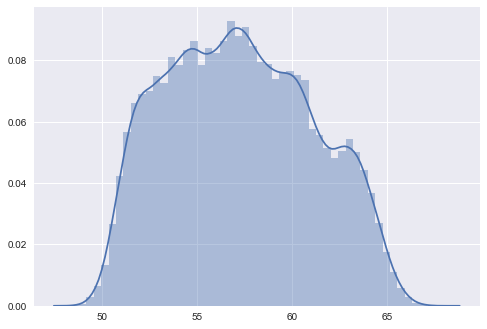

In [12]:
sns.distplot(Tms)

In [13]:
chip1_data=pd.read_csv(f'{path_to_synthesis_files}chip1_GAS_nredundant.csv') #designed sequences
doubles=pd.read_csv(f'{path_to_synthesis_files}backfill_random_doubles.csv') #backfill the chip with random doubles if there is room
singles=pd.read_csv(f'{path_to_synthesis_files}singles.csv',index_col=0) #single mutations
wild_type=pd.DataFrame([["wild_type",1,WT_AA_AAV2_T21]],columns=["category","control","sequence"])
chip1_data=chip1_data.append(doubles)
chip1_data=chip1_data.append(singles)
chip1_data=chip1_data.append(wild_type)
chip1_data=chip1_data.reset_index(drop=1)
chip1_data.head()

,category,control,sequence
0,rnn_designed_plus_rand_train_walked,0.0,DEDEIRTTNPVATEQYGSVSTNLgGEGdNR
1,rnn_designed_plus_rand_train_walked,0.0,DEDEIRTTNPVATEQYGSVSTNLQDnGnNdR
2,rnn_designed_plus_rand_train_walked,0.0,DEDEIRTTNPVATEQYGAVSTNLQGdGNdR
3,rnn_designed_plus_rand_train_walked,0.0,DEEEIATTNPVATEQYGSVSTNLQHdGDeR
4,rnn_designed_plus_rand_train_walked,0.0,DEHEIRTTNPVATEQYGNVSTNLQGgGdNR


In [14]:
len(singles.sequence) # (ins)29*21+(subs)28*20

1169

In [15]:
chip1_data.tail()

,category,control,sequence
241465,singles,1.0,tDEEEIRTTNPVATEQYGSVSTNLQRGNR
241466,singles,1.0,vDEEEIRTTNPVATEQYGSVSTNLQRGNR
241467,singles,1.0,wDEEEIRTTNPVATEQYGSVSTNLQRGNR
241468,singles,1.0,yDEEEIRTTNPVATEQYGSVSTNLQRGNR
241469,wild_type,1.0,DEEEIRTTNPVATEQYGSVSTNLQRGNR


In [16]:
len(chip1_data)

241470

In [17]:
len(chip1_data[chip1_data.control==0]),len(chip1_data[chip1_data.control==1]),len(chip1_data[chip1_data["category"]=="random_doubles"])

(236051, 5419, 33320)

In [18]:
for i in set(chip1_data[chip1_data.control==1]["category"]):
 print (i)
 print(len(chip1_data[(chip1_data.control==1)&(chip1_data.category==i)]))

rnn_standard_walked
250
wild_type
1
previous_chip_viable
1000
cnn_designed_plus_rand_train_walked
250
rnn_designed_plus_rand_train_walked
250
rnn_rand_doubles_plus_singles_walked
250
singles
1112
cnn_standard_walked
250
previous_chip_nonviable
1000
cnn_rand_doubles_plus_single_walked
250
lr_standard_walked
250
lr_rand_doubles_plus_single_walked
249
lr_designed_plus_rand_train_walked
250
stop
57


In [19]:
def create_backtranslation_table(include_stops = False):
    codon_aa = CodonTable.unambiguous_dna_by_name["Standard"].forward_table
    if include_stops:
        codon_aa['TAG']='*'
        codon_aa['TAA']='*'
        codon_aa['TGA']='*'
    aa_codon = {}
    for codon in codon_aa:
        # print codon, codon_aa[codon]
        aa = codon_aa[codon]
        if aa in aa_codon:
            aa_codon[aa].append(codon)
        else:
            aa_codon[aa] = [codon]
    return aa_codon

In [20]:
aa_codon=create_backtranslation_table(include_stops=True)

In [21]:
#re_sites=augment_with_reverse_complements([x.site for x in [BbsI, BsaI, BsmBI, EcoRV,HindIII, XbaI,ScaI]])
re_sites=re_list
re_sites

['GGTCTC',
 'GAGACC',
 'AAGCTT',
 'TCTAGA',
 'GAAGAC',
 'GTCTTC',
 'CGTCTC',
 'GAGACG',
 'GATATC',
 'CCGCTC',
 'GAGCGG',
 'AAAAA',
 'CCCCC',
 'GGGGG',
 'TTTTT']

In [22]:
mutants=list(chip1_data[chip1_data.control==0].sequence)
len(mutants)

236051

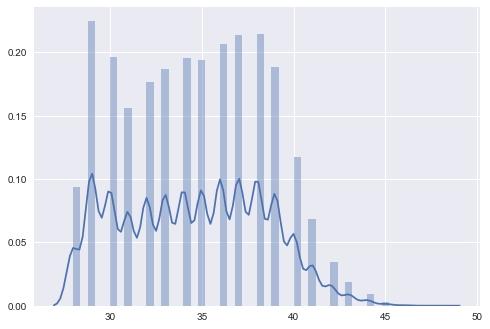

In [23]:
len_muts=[len(i) for i in mutants]
sns.distplot(len_muts)

In [24]:
too_long=list(filter(lambda x: x>43, len_muts))

In [25]:
len(too_long)/len(len_muts),len(too_long)

(0.005515757188065291, 1302)

In [38]:
#Pre computation check of key functions
def test_back_translate(mutants):
    """Check cycle consistency"""
    for mut in random.sample(mutants,10000):
         assert mut.upper()==str(Seq(backtranslate(mut,aa_codon)).translate()),"back translate failed to produce the same sequence"
    else:
         print ("Back translate test Passed")

def test_mutate_away(mutants,enzyme_sites,aa_codon):
    needed_mutation_away=0
    for mut in mutants:
        mut_nt=str(Seq(backtranslate(mut,aa_codon)))
        if check_re_sites(mut_nt,enzyme_sites)>0:
            needed_mutation_away+=1
            new_seq=mutate_away_sites(mut_nt,enzyme_sites,aa_codon)
            
            assert mut.upper()==str(Seq(new_seq).translate()),"mutate away introduced mutation in sequence"
    else:
        print ("Successfully mutated away {num} sequences".format(num=needed_mutation_away))
            
def test_check_re_site(re_sites,num_attempts=1000):
    for i in range(num_attempts):
        sequence_to_check=[]

        num_sites=random.randint(0,100)
        for j in range(num_sites):
            sequence_to_check.extend([random.choice(re_sites)]+["X"*random.randint(0,10)])
        str_seq="".join(sequence_to_check)
        #print (str_seq, num_sites,check_re_sites(str_seq,re_sites))
        assert check_re_sites(str_seq,re_sites)==num_sites, "RE sites function failed to reproduce the expected results"
    else:
        print ("Successfully checked for RE sites in {num} sequences with check_re_sites()".format(num=num_attempts))
    
#test_back_translate(mutants)
#test_mutate_away(mutants,re_sites,aa_codon)
test_check_re_site(re_sites,10000)

Successfully checked for RE sites in 10000 sequences with check_re_sites()


In [26]:
fwd_file = f'{path_to_synthesis_files}skpp15-forward.fasta'
rev_file = f'{path_to_synthesis_files}skpp15-reverse.fasta'

hF = open(fwd_file, "r")
hR = open(rev_file, "r")
primersF = list(SeqIO.parse(hF, "fasta"))
primersR = list(SeqIO.parse(hR, "fasta"))
hF.close()
hR.close()

In [27]:
OH_seq_5="ATTACA"
OH_seq_3="CAAGC"
OH_barcode_5,OH_barcode_3,start_filter,end_filter=compute_BC_OH(BsrBI)

CGCTAA


In [28]:
good_primersF=[]
good_primersR=[]
for f,r in zip(primersF,primersR):
   # print (f.seq,r.seq.reverse_complement())
    seq_f=str(f.seq)
    seq_r=str(r.seq.reverse_complement())
    if (check_re_sites(seq_f,re_sites)+check_re_sites(seq_r,re_sites))==0:        
        good_primersF.append(f)
        good_primersR.append(r)

In [29]:
primer_id_to_use=0 #zero indexed

In [30]:
success_mutants=[]
failed_mutants=[]
primers_size=len(good_primersF)
skipped_barcodes=[]
barcode_index=0

for i,row in chip1_data[chip1_data.control==0].iterrows():
    
    mutant=row["sequence"]
    label=row["category"]
    oligo_obj=Oligo(debug=False)
    oligo_obj.set_restriction_enzymes_to_avoid([x.site for x in [HindIII, XbaI,BsrBI,BsmBI]])
    oligo_obj.set_targeted_restriction_enzymes([x.site for x in [BbsI, BsaI, EcoRV]])
    oligo_obj.set_homopolymer(homopolymer)
    
    primerF=str(good_primersF[primer_id_to_use].seq) 
    primerR=str(good_primersR[primer_id_to_use].seq.reverse_complement())
    
    oligo_obj.assemble_upstream(primerF,BbsI.site,OH_seq_5) #BbsI
    rev_comp_BsaI=str(Seq(BsaI.site).reverse_complement())
    
    pre_barcode=OH_seq_3+rev_comp_BsaI+EcoRV.site+BsaI.site+OH_barcode_5
    current_barcode=barcodes[barcode_index]
    rev_comp_BbsI= str(Seq(BbsI.site).reverse_complement())

    post_barcode=OH_barcode_3+rev_comp_BbsI+primerR
    while not oligo_obj.assemble_downstream(pre_barcode,current_barcode,post_barcode):
        skipped_barcodes.append(barcode_index)
        barcode_index+=1
        if barcode_index>=len(barcodes):
            print ("ran out of barcodes!")
            
        current_barcode=barcodes[barcode_index]
    mut_nt=str(Seq(backtranslate(mutant,aa_codon,wt_nt_seq=WT_NT_AAV2_T21,default_wt=True))) 
    [full_seq,selected_barcode]=oligo_obj.assemble_full_sequence(mut_nt,aa_codon=aa_codon)
    if full_seq:
       coding_sequence=full_seq[len(oligo_obj.upstream):-len(oligo_obj.downstream)]
       success_mutants.append([full_seq,selected_barcode,mutant,label,coding_sequence])
       barcode_index+=1
    else:
       failed_mutants.append((check_re_sites(oligo_obj.upstream+mut_nt+oligo_obj.downstream,re_sites),oligo_obj.upstream,mut_nt,oligo_obj.downstream,mutant)) 
    

In [31]:
len(success_mutants)

234747

In [32]:
success_mutants[0][0]

'GGGTCACGCGTAGGAGAAGACATTACAGACGAAGATGAAATCAGGACAACCAATCCCGTGGCTACGGAGCAGTATGGTTCTGTATCTACCAACCTCGGGGGGGAAGGCGACAACAGACAAGCGAGACCGATATCGGTCTCACGCTGTGTGTCCAGAATGCGGTCGCTAAGTCTTCGTGTGGCTGCGGAAC'

In [33]:
success_mutants[0]

['GGGTCACGCGTAGGAGAAGACATTACAGACGAAGATGAAATCAGGACAACCAATCCCGTGGCTACGGAGCAGTATGGTTCTGTATCTACCAACCTCGGGGGGGAAGGCGACAACAGACAAGCGAGACCGATATCGGTCTCACGCTGTGTGTCCAGAATGCGGTCGCTAAGTCTTCGTGTGGCTGCGGAAC',
 'GTGTGTCCAGAATGCGGT',
 'DEDEIRTTNPVATEQYGSVSTNLgGEGdNR',
 'rnn_designed_plus_rand_train_walked',
 'GACGAAGATGAAATCAGGACAACCAATCCCGTGGCTACGGAGCAGTATGGTTCTGTATCTACCAACCTCGGGGGGGAAGGCGACAACAGA']

In [34]:
len(failed_mutants)

1304

In [35]:
failed_mutants[0]

(7,
 'GGGTCACGCGTAGGAGAAGACATTACA',
 'ACAGACGAGGAATGCATCAGGACAACCGCAACCAATCCCGTGGCTACCACGGGCGTGGGGGCGGAAGGGTGGGGTTCTGTAGCGTGTACCATTAACGGAGAGCAGATAGAGGGGGGCGGAAACGCGCCGAGG',
 'CAAGCGAGACCGATATCGGTCTCACGCTAGCCGGTCGCTTACAACACGCTAAGTCTTCGTGTGGCTGCGGAAC',
 'TDEEcIRTTaTnPVAtTgVgAeGwGSVAcTInGeQiEgGgNaPr')

In [45]:
"% Barcodes discarded:",(100*(barcode_index-len(success_mutants)))/barcode_index
"% Barcodes skipped:",(100*len(skipped_barcodes))/barcode_index

('% Barcodes skipped:', 1.5797748569272372)

### Post generation testing.

In [48]:
#check all 
def check_num_re_sites(mutants,re_sites_x):
    count=0
    sites=[]
    for mutant_group in mutants:
        mutant=mutant_group[0]
        num_site=check_re_sites(mutant,re_sites_x)
        num_site2=check_re_sites_non_overlapping(mutant,re_sites_x)
        assert num_site ==5 & num_site2==5, "Wrong number of re sites %s %s %s" %(num_site,num_site2,mutant)

    else:
        print ("Success: Correct num of re sites")
check_num_re_sites(success_mutants,re_sites[:-4])

Success: Correct num of re sites


In [49]:
def count_homopolymers(mutants,homopolymer):
    count=0
    on_seq=0
    for mutant_group in mutants:
        mutant=mutant_group[0]
        num_site=check_re_sites(mutant,homopolymer)
        if num_site!=0:
           count+=num_site
           on_seq+=1
    return "Found %s sites on %s oligos" %(count,on_seq)

count_homopolymers(success_mutants,re_sites[-4:])


'Found 28112 sites on 26334 oligos'

In [50]:
def check_cut_site_counts(sequences):
    for seq in sequences:
        assert check_re_sites(seq[0],augment_with_reverse_complements([BbsI.site]))==2,  "Wrong count BbsI sites"
        assert check_re_sites(seq[0],augment_with_reverse_complements([BsaI.site]))==2,  "Wrong count BsaI sites"
        assert check_re_sites(seq[0],augment_with_reverse_complements([BsrBI.site]))==0,  "Wrong count BsrBI sites"
        assert check_re_sites(seq[0],augment_with_reverse_complements([EcoRV.site]))==1,  "Wrong count EcoRV sites"
        assert check_re_sites(seq[0],augment_with_reverse_complements([BsmBI.site]))==0,  "Wrong count BsmbI sites"
        assert check_re_sites_non_overlapping(seq[0],augment_with_reverse_complements([BbsI.site]))==2,  "Wrong count BbsI sites"
        assert check_re_sites_non_overlapping(seq[0],augment_with_reverse_complements([BsaI.site]))==2,  "Wrong count BsaI sites"
        assert check_re_sites_non_overlapping(seq[0],augment_with_reverse_complements([EcoRV.site]))==1,  "Wrong count EcoRV sites"
    else:
        print ("Correct count for BbsI, BsaI, EcoRV,ScaI")

check_cut_site_counts(success_mutants)

Correct count for BbsI, BsaI, EcoRV,ScaI


In [51]:
import re
def get_cut_locations(sequences,enzyme_site):
    cut_locs=[]
    for seq in sequences:
        site_loc = re.finditer(enzyme_site, seq[0].upper())
        cut_locs.extend(site_loc)
    return [c.span()[0] for c in cut_locs]

def get_cut_site_distances(sequences,enzyme_site):
    cut_locs=[]
    for seq in sequences:
        site_loc = re.finditer(enzyme_site, seq[0].upper())
        site_loc=list(site_loc)
        site1=site_loc[0].span()[0]
        site2=site_loc[1].span()[0]
        cut_locs.append(site2-site1)
    return cut_locs

In [52]:
barcode_index

238515

In [53]:
success_mutants_control=[]
failed_mutants_control=[]
primers_size=len(good_primersF)
#skipped_barcodes=[]
#barcode_index=0
for i,row in chip1_data[chip1_data.control==1].iterrows():
    mutant=row["sequence"]
    label=row["category"]
    if label=="singles":
        reps=4
    elif label=="stop":
        reps=3
    elif label=="wild_type":
        reps=200
    else:
        reps=3
    for j in range(reps):
        oligo_obj=Oligo(debug=False)
        oligo_obj.set_restriction_enzymes_to_avoid([x.site for x in [HindIII, XbaI, BsrBI, BsmBI]]) 
        oligo_obj.set_targeted_restriction_enzymes([x.site for x in [BbsI, BsaI, EcoRV]])
        oligo_obj.set_homopolymer(homopolymer)

        primerF=str(good_primersF[primer_id_to_use].seq)
        primerR=str(good_primersR[primer_id_to_use].seq.reverse_complement())
        oligo_obj.assemble_upstream(primerF,BbsI.site,OH_seq_5) #BbsI
        rev_comp_BsaI=str(Seq(BsaI.site).reverse_complement())
        pre_barcode=OH_seq_3+rev_comp_BsaI+EcoRV.site+BsaI.site+OH_barcode_5
        current_barcode=barcodes[barcode_index]
        rev_comp_BbsI= str(Seq(BbsI.site).reverse_complement())

        post_barcode=OH_barcode_3+rev_comp_BbsI+primerR
        while not oligo_obj.assemble_downstream(pre_barcode,current_barcode,post_barcode):
            skipped_barcodes.append(barcode_index)
            barcode_index+=1
            if barcode_index>=len(barcodes):
                print ("ran out of barcodes!")

            current_barcode=barcodes[barcode_index]
        if j<1:
                if label=="stop" and len(mutant)>28:
                    mut_nt_0=str(Seq(backtranslate(mutant,aa_codon)))
                    [full_seq,sel_barcode]=oligo_obj.assemble_full_sequence(mut_nt_0,aa_codon=aa_codon)

                else:
                    mut_nt_0=str(Seq(backtranslate(mutant,aa_codon,wt_nt_seq=WT_NT_AAV2_T21,default_wt=True))) 
                    [full_seq,sel_barcode]=oligo_obj.assemble_full_sequence(mut_nt_0,aa_codon=aa_codon)
                mut_nt=str(mut_nt_0)    
            
        elif j<2 and label=="singles":
                mut_nt_0=str(Seq(backtranslate(mutant,aa_codon,wt_nt_seq=WT_NT_AAV2_T21,default_wt=True))) 
                [full_seq,sel_barcode]=oligo_obj.assemble_full_sequence(mut_nt_0,aa_codon=aa_codon)
                mut_nt=str(mut_nt_0)
         
        else:
            mut_nt=str(Seq(backtranslate(mutant,aa_codon))) 
            while mut_nt==mut_nt_0:
                mut_nt=str(Seq(backtranslate(mutant,aa_codon))) 
                assert mutant==str(Seq(mut_nt_0).translate()), "Failed to match original"
            [full_seq,sel_barcode]=oligo_obj.assemble_full_sequence(mut_nt,aa_codon=aa_codon) 
            
            
        if full_seq:
           coding_sequence=full_seq[len(oligo_obj.upstream):-len(oligo_obj.downstream)]
           rep_index=j+1
           success_mutants_control.append([full_seq,sel_barcode,mutant,label,coding_sequence,rep_index])
           barcode_index+=1
        else:
           failed_mutants_control.append((check_re_sites(oligo_obj.upstream+mut_nt+oligo_obj.downstream,re_sites),oligo_obj.upstream,mut_nt,oligo_obj.downstream,mutant)) 
    

In [54]:
success_mutants_control[-1]

['GGGTCACGCGTAGGAGAAGACATTACAGACGAGGAGGAAATTCGCACTACTAACCCAGTTGCTACAGAGCAATATGGTTCTGTCTCTACGAATCTACAGCGGGGAAACAGACAAGCGAGACCGATATCGGTCTCACGCTAGAAGTCTAAGCTATCAGCGCTAAGTCTTCGTGTGGCTGCGGAAC',
 'AGAAGTCTAAGCTATCAG',
 'DEEEIRTTNPVATEQYGSVSTNLQRGNR',
 'wild_type',
 'GACGAGGAGGAAATTCGCACTACTAACCCAGTTGCTACAGAGCAATATGGTTCTGTCTCTACGAATCTACAGCGGGGAAACAGA',
 200]

In [55]:
len(chip1_data[chip1_data.control==1])

5419

In [56]:
len(chip1_data[(chip1_data.control==1)&(chip1_data.sequence.str.len()>43)])

21

In [57]:
len(set(failed_mutants_control))/3

21.0

In [58]:
check_cut_site_counts(success_mutants_control)
check_num_re_sites(success_mutants_control,re_sites[:-4])

Correct count for BbsI, BsaI, EcoRV,ScaI
Success: Correct num of re sites


In [59]:
# currently unnecessarily slow
def make_dataframe(success,input_df,control):
    
    data=pd.DataFrame(columns=["category","control","rep","aa_seq","barcode","coding","full_nt_seq"])
    new_rows=[]
    for i,mut in enumerate(success):
        aa_seq=mut[2]
        category=mut[3]
        if control==1:
            rep_index=mut[5]
        else:
            rep_index=1
        try:
            new_rows.append([category,control,rep_index,aa_seq,mut[1],mut[4],mut[0]])
        except:
            print (row["category"])
        if i>0 and i%20000==0:
            print (i)  
            new_data=pd.DataFrame(new_rows,columns=["category","control","rep","aa_seq","barcode","coding","full_nt_seq"])
            data=data.append(new_data)
            new_rows=[]

    new_data=pd.DataFrame(new_rows,columns=["category","control","rep","aa_seq","barcode","coding","full_nt_seq"])
    data=data.append(new_data)
    return data

In [60]:
normal_data=make_dataframe(success_mutants,chip1_data[chip1_data.control==0],0)

20000
40000
60000
80000
100000
120000
140000
160000
180000
200000
220000


In [61]:
normal_data.head()

,category,control,rep,aa_seq,barcode,coding,full_nt_seq
0,rnn_designed_plus_rand_train_walked,0,1,DEDEIRTTNPVATEQYGSVSTNLgGEGdNR,GTGTGTCCAGAATGCGGT,GACGAAGATGAAATCAGGACAACCAATCCCGTGGCTACGGAGCAGT...,GGGTCACGCGTAGGAGAAGACATTACAGACGAAGATGAAATCAGGA...
1,rnn_designed_plus_rand_train_walked,0,1,DEDEIRTTNPVATEQYGSVSTNLQDnGnNdR,GTCCGTTCTAATATCAGA,GACGAGGACGAAATCAGGACAACCAATCCCGTGGCTACGGAGCAGT...,GGGTCACGCGTAGGAGAAGACATTACAGACGAGGACGAAATCAGGA...
2,rnn_designed_plus_rand_train_walked,0,1,DEDEIRTTNPVATEQYGAVSTNLQGdGNdR,GCTAATCACACGTTGCAT,GACGAGGACGAAATCAGGACAACCAATCCCGTGGCTACGGAGCAGT...,GGGTCACGCGTAGGAGAAGACATTACAGACGAGGACGAAATCAGGA...
3,rnn_designed_plus_rand_train_walked,0,1,DEEEIATTNPVATEQYGSVSTNLQHdGDeR,GAAGGAACTGGAACTGTA,GACGAAGAGGAAATCGCTACAACCAATCCCGTGGCTACGGAGCAGT...,GGGTCACGCGTAGGAGAAGACATTACAGACGAAGAGGAAATCGCTA...
4,rnn_designed_plus_rand_train_walked,0,1,DEHEIRTTNPVATEQYGNVSTNLQGgGdNR,AGGACAGCTAACCTCAAT,GACGAACACGAAATCAGGACAACCAATCCCGTGGCTACGGAGCAGT...,GGGTCACGCGTAGGAGAAGACATTACAGACGAACACGAAATCAGGA...


In [62]:
control_data=make_dataframe(success_mutants_control,chip1_data[chip1_data.control==1],1)

In [63]:
control_data.head()

,category,control,rep,aa_seq,barcode,coding,full_nt_seq
0,rnn_designed_plus_rand_train_walked,1,1,DESEIATTNPVATEHYGSVSTNLQRdGNP,GTTACCACCAGTCCACAG,GACGAATCGGAAATCGCAACAACCAATCCCGTGGCTACGGAGCACT...,GGGTCACGCGTAGGAGAAGACATTACAGACGAATCGGAAATCGCAA...
1,rnn_designed_plus_rand_train_walked,1,2,DESEIATTNPVATEHYGSVSTNLQRdGNP,ACTCGCTGACGCCTCTAT,GACGAATCGGAGATAGCCACCACAAATCCCGTAGCAACCGAGCACT...,GGGTCACGCGTAGGAGAAGACATTACAGACGAATCGGAGATAGCCA...
2,rnn_designed_plus_rand_train_walked,1,3,DESEIATTNPVATEHYGSVSTNLQRdGNP,TGTCGATTGCTTCTTGAT,GATGAATCAGAAATAGCTACAACCAATCCAGTTGCCACAGAGCATT...,GGGTCACGCGTAGGAGAAGACATTACAGATGAATCAGAAATAGCTA...
3,rnn_designed_plus_rand_train_walked,1,1,DEEEIATTNPVATEQYGSVSTNLQQsGDnR,TCCTCGTTAGTTACCACA,GACGAAGAGGAAATCGCTACAACCAATCCCGTGGCTACGGAGCAGT...,GGGTCACGCGTAGGAGAAGACATTACAGACGAAGAGGAAATCGCTA...
4,rnn_designed_plus_rand_train_walked,1,2,DEEEIATTNPVATEQYGSVSTNLQQsGDnR,AGTGGTTAGACATATTCT,GACGAAGAGGAAATTGCAACCACAAACCCTGTAGCGACCGAGCAGT...,GGGTCACGCGTAGGAGAAGACATTACAGACGAAGAGGAAATTGCAA...


In [64]:
control_data.tail()

,category,control,rep,aa_seq,barcode,coding,full_nt_seq
17498,wild_type,1,196,DEEEIRTTNPVATEQYGSVSTNLQRGNR,ATTGCCGAGTATTCTTGA,GACGAAGAGGAGATACGAACTACGAATCCTGTGGCTACGGAGCAAT...,GGGTCACGCGTAGGAGAAGACATTACAGACGAAGAGGAGATACGAA...
17499,wild_type,1,197,DEEEIRTTNPVATEQYGSVSTNLQRGNR,TCTCGCAGGTTGTATCAG,GATGAAGAAGAAATCAGGACGACAAACCCGGTTGCGACGGAACAGT...,GGGTCACGCGTAGGAGAAGACATTACAGATGAAGAAGAAATCAGGA...
17500,wild_type,1,198,DEEEIRTTNPVATEQYGSVSTNLQRGNR,TGCGGTGTCTATACGATA,GACGAGGAAGAGATCAGAACGACAAACCCCGTAGCAACAGAACAAT...,GGGTCACGCGTAGGAGAAGACATTACAGACGAGGAAGAGATCAGAA...
17501,wild_type,1,199,DEEEIRTTNPVATEQYGSVSTNLQRGNR,TCACGGAGATTGGATGCT,GATGAAGAAGAGATACGTACGACTAACCCGGTGGCGACTGAGCAAT...,GGGTCACGCGTAGGAGAAGACATTACAGATGAAGAAGAGATACGTA...
17502,wild_type,1,200,DEEEIRTTNPVATEQYGSVSTNLQRGNR,AGAAGTCTAAGCTATCAG,GACGAGGAGGAAATTCGCACTACTAACCCAGTTGCTACAGAGCAAT...,GGGTCACGCGTAGGAGAAGACATTACAGACGAGGAGGAAATTCGCA...


In [65]:
len(normal_data),len(control_data)

(234747, 17503)

In [66]:
def test_data_frame(df):
    bc_lengths=set(list(filter(lambda x: len(x)!=18, df["barcode"])))
   # print (bc_lengths)
    
    assert len(bc_lengths)==0, "variable barcode length"
    assert len(df["barcode"])==len(set(df["barcode"])),"non unique barcode"
    
    try:
        assert len(df["coding"])==len(set(df["coding"])),"non unique coding region"
    except:
        print (len(df[df.duplicated("coding", keep=False)]),"duplicated coding regions")
        
    for i, row in df.iterrows():
        nt=row["coding"]
        aa=str(Seq(nt).translate())
        assert row["barcode"] in row["full_nt_seq"], "barcode not paired with full seq"
        assert aa==str(row["aa_seq"]).upper(), "wrong translation"
        assert row["full_nt_seq"].startswith(str(good_primersF[primer_id_to_use].seq)), "wrong start primer"
        assert row["full_nt_seq"].endswith(str(good_primersR[primer_id_to_use].seq.reverse_complement())),"wrong end primer"
        
    print ("All tests passed")
    

In [67]:
all_data=normal_data[normal_data.category!="random_doubles"].append(control_data)
all_data=all_data.append(normal_data[normal_data.category=="random_doubles"])
all_data=all_data.reset_index(drop=True)
all_data.head()

,category,control,rep,aa_seq,barcode,coding,full_nt_seq
0,rnn_designed_plus_rand_train_walked,0,1,DEDEIRTTNPVATEQYGSVSTNLgGEGdNR,GTGTGTCCAGAATGCGGT,GACGAAGATGAAATCAGGACAACCAATCCCGTGGCTACGGAGCAGT...,GGGTCACGCGTAGGAGAAGACATTACAGACGAAGATGAAATCAGGA...
1,rnn_designed_plus_rand_train_walked,0,1,DEDEIRTTNPVATEQYGSVSTNLQDnGnNdR,GTCCGTTCTAATATCAGA,GACGAGGACGAAATCAGGACAACCAATCCCGTGGCTACGGAGCAGT...,GGGTCACGCGTAGGAGAAGACATTACAGACGAGGACGAAATCAGGA...
2,rnn_designed_plus_rand_train_walked,0,1,DEDEIRTTNPVATEQYGAVSTNLQGdGNdR,GCTAATCACACGTTGCAT,GACGAGGACGAAATCAGGACAACCAATCCCGTGGCTACGGAGCAGT...,GGGTCACGCGTAGGAGAAGACATTACAGACGAGGACGAAATCAGGA...
3,rnn_designed_plus_rand_train_walked,0,1,DEEEIATTNPVATEQYGSVSTNLQHdGDeR,GAAGGAACTGGAACTGTA,GACGAAGAGGAAATCGCTACAACCAATCCCGTGGCTACGGAGCAGT...,GGGTCACGCGTAGGAGAAGACATTACAGACGAAGAGGAAATCGCTA...
4,rnn_designed_plus_rand_train_walked,0,1,DEHEIRTTNPVATEQYGNVSTNLQGgGdNR,AGGACAGCTAACCTCAAT,GACGAACACGAAATCAGGACAACCAATCCCGTGGCTACGGAGCAGT...,GGGTCACGCGTAGGAGAAGACATTACAGACGAACACGAAATCAGGA...


In [68]:
str(good_primersF[primer_id_to_use].seq)
#primersF[0]

'GGGTCACGCGTAGGA'

In [69]:
test_data_frame(control_data)
test_data_frame(all_data)

978 duplicated coding regions
All tests passed
1051 duplicated coding regions
All tests passed


In [70]:
len(all_data)

252250

In [273]:
len(control_data)

17503

In [73]:
#all_data.to_csv(f'{path_to_synthesis_files}chip_df.csv")